In [41]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import hvplot.pandas

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')


## All counties in USA by county code

In [3]:
# Load the workbook
file_id = '1i1yi96kf3-7oK_PJadb0ik9iPxLfg5rH'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'county_codes.xlsx')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

all_counties_df = pd.read_excel(filename)

# # Display the first few rows of the DataFrame
# display(all_counties_df.sample(30))
# print("Total number of rows in all_counties_df:", all_counties_df.shape[0])

Downloading...
From: https://drive.google.com/uc?id=1i1yi96kf3-7oK_PJadb0ik9iPxLfg5rH
To: /Users/a/Desktop/GVD_Data/county_codes.xlsx
100%|███████████████████████████████████████| 96.3k/96.3k [00:00<00:00, 372kB/s]


## Gun deaths by county, https://data.world/nkrishnaswami/gun-deaths-by-county

In [4]:
# Read the TSV data
file_id = '1wMGT_7czWTYO6iFIUmK9m_1b7KYVlp2n'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'Gun Deaths by County, 1999-2020.tsv')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)


# # Read the TSV data
# file_id = '1wMGT_7czWTYO6iFIUmK9m_1b7KYVlp2n'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', 'Gun Deaths by County, 1999-2020.tsv', quiet=False)
df = pd.read_csv(filename, sep='\t')

# Create new columns for state and county

# Split the 'county_name' column on the comma
df[['county', 'state']] = df['county_name'].str.split(',', expand=True)

# Now we have 'County' in the county names, let's remove it
df['County'] = df['county'].str.replace(' County', '')

# The state might have leading spaces, let's remove them
df['State'] = df['state'].str.strip()


# drop the columns: 'county', 'state', county_name', crude_rate', 'crude_rate_lower_95_confidence_interval', 'crude_rate_upper_95_confidence_interval', 'age_adjusted_rate', 'age_adjusted_rate_lower_95_confidence_interval', 'age_adjusted_rate_upper_95_confidence_interval'
columns_to_drop = ['county', 'state', 'county_name', 'crude_rate', 'crude_rate_lower_95_confidence_interval', 'crude_rate_upper_95_confidence_interval', 'age_adjusted_rate', 'age_adjusted_rate_lower_95_confidence_interval', 'age_adjusted_rate_upper_95_confidence_interval']

# rename the dataframe
county_deaths_df = df.drop(columns = columns_to_drop)

# create a new column to get death rate per 100K people
county_deaths_df['deaths_per_100K'] = ((county_deaths_df['deaths'] / county_deaths_df['population']) * 100000).round(3)

# groupby county for all the years
county_stats_df = county_deaths_df.groupby('county_code').agg(
    {
        'deaths_per_100K': ['mean', 'std', 'count'],  # add 'count' aggregation function here
        'County': 'first',  # keep the first 'county_code' for each county
        'State': 'first'  # keep the first 'State' for each county
    }
)

# Rename the columns
county_stats_df.columns = ['deaths_per_100K_mean', 'deaths_per_100K_std', 'deaths_per_100K_numb_years', 'County', 'State']

county_stats_df.reset_index(inplace=True)

# Reorder columns
county_stats_df = county_stats_df.reindex(columns=['County', 'State', 'county_code', 'deaths_per_100K_mean', 'deaths_per_100K_std', 'deaths_per_100K_numb_years'])


# # print a sample of the dataframe
# display(county_stats_df.head(50))
# print("Total number of rows in county_stats_df:", county_stats_df.shape[0])



Downloading...
From: https://drive.google.com/uc?id=1wMGT_7czWTYO6iFIUmK9m_1b7KYVlp2n
To: /Users/a/Desktop/GVD_Data/Gun Deaths by County, 1999-2020.tsv
100%|██████████████████████████████████████| 1.20M/1.20M [00:01<00:00, 1.02MB/s]


## Merging 'all_counties_df' and 'county_stats_df' and where there is no match, the 'deaths' columns will be zero

In [5]:
merged_df = all_counties_df.merge(county_stats_df, on='county_code', how='left')

# Fill NaN values with 0
merged_df['deaths_per_100K_mean'].fillna(0, inplace=True)
merged_df['deaths_per_100K_std'].fillna(0, inplace=True)
merged_df['deaths_per_100K_numb_years'].fillna(0, inplace=True)

# rename the file
counties_gun_df = merged_df

# rename columns
counties_gun_df = counties_gun_df.rename(columns={'State_x': 'state', 'County_x': 'county'})

# drop unwanted columns
counties_gun_df = counties_gun_df.drop(columns=['State_y', 'County_y'])

#_________________________________________________________________________________________

# read in the states_df to get state abbreviations

# Read the CSV data
states_df = pd.read_csv('../Data/50+States.csv')

# rename 'State' to 'state'
states_df = states_df.rename(columns={"State": "state"})

#_________________________________________________________________________________________

# add the state abbreviations to the 'counties_gun_df'
counties_gun_df = pd.merge(counties_gun_df, states_df[['state', 'Abbr']], on='state', how='left')

# change column order
counties_gun_df = counties_gun_df[['state', 'Abbr', 'county', 'county_code', 'deaths_per_100K_mean', 'deaths_per_100K_std', 'deaths_per_100K_numb_years']]


# # print a sample of the dataframe
# display(counties_gun_df.sample(50))
# print("Total number of rows in counties_gun_df:", counties_gun_df.shape[0])


## adding education to the dataframe (https://data.world/usda/county-level-data-sets)

In [6]:
# Load the workbook
file_id = '1xo7QDyfA7Uk9LMwddul3skS_PmpLnFa9'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'Education.xls')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

excel_file = filename

# Load a specific worksheet
education_df = pd.read_excel(excel_file, sheet_name='Education 1970 to 2014')

# get only pertinent columns
education_2010_df = education_df[['county_code', 'State', 'Area name', 'Percent of adults with less than a high school diploma, 2010-2014', 'Percent of adults with a high school diploma only, 2010-2014', "Percent of adults completing some college or associate's degree, 2010-2014", "Percent of adults with a bachelor's degree or higher, 2010-2014"]]

# merge 'education_2010_df' and 'counties_gun_df' on 'county_code'
merged_df = education_2010_df.merge(counties_gun_df, on='county_code')

# rename the merged_df
counties_gun2_df = merged_df

# # Display the first few rows of the DataFrame
# display(counties_gun2_df.sample(30))
# print("Total number of rows in counties_gun2_df:", counties_gun2_df.shape[0])




Downloading...
From: https://drive.google.com/uc?id=1xo7QDyfA7Uk9LMwddul3skS_PmpLnFa9
To: /Users/a/Desktop/GVD_Data/Education.xls
100%|██████████████████████████████████████| 3.00M/3.00M [00:01<00:00, 1.51MB/s]


## add unemployment rate to the dataframe (https://data.world/usda/county-level-data-sets)

In [7]:
# Load the workbook
file_id = '1CHcfY5VGBUV5xLUuoiamAbn1g1nTQLWB'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'Unemployment.xlsx')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

excel_file = filename

# Load a specific worksheet
unemp_df = pd.read_excel(excel_file, sheet_name='Unemployment Update')

# rename 'FIPStxt' to 'county_code'
unemp_df = unemp_df.rename(columns={"FIPS_Code": "county_code"})

# Select the 'county_code' and 'state' columns
unemp_subset = unemp_df[['county_code', 'State']].copy()

# rename 'State' to 'state'
unemp_subset = unemp_subset.rename(columns={"State": "state"})


# Create a new column 'avg_unemp_rate_2010_2015' that is the average of the unemployment rate from 2010 to 2015
unemp_subset['avg_unemp_rate_2010_2015'] = unemp_df[['Unemployment_rate_2010', 'Unemployment_rate_2011', 'Unemployment_rate_2012', 'Unemployment_rate_2013', 'Unemployment_rate_2014', 'Unemployment_rate_2015']].mean(axis=1)

# rename the dataframe
unemp_2010to2015_df = unemp_subset

# merge 'unemp_2010to2015_df' and 'counties_gun2_df' on 'county_code'
merged_df = unemp_2010to2015_df.merge(counties_gun2_df, on='county_code')

# rename the merged_df
counties_gun3_df = merged_df

# Drop the 'state_x' and 'state_y' columns
counties_gun3_df = counties_gun3_df.drop(['state_x', 'state_y'], axis=1)

# Rename the 'State' column to 'state'
counties_gun3_df = counties_gun3_df.rename(columns={'State': 'state'})


# # Display the first few rows of the DataFrame
# display(counties_gun3_df.sample(30))
# print("Total number of rows in counties_gun3_df:", counties_gun3_df.shape[0])



Downloading...
From: https://drive.google.com/uc?id=1CHcfY5VGBUV5xLUuoiamAbn1g1nTQLWB
To: /Users/a/Desktop/GVD_Data/Unemployment.xlsx
100%|██████████████████████████████████████| 1.02M/1.02M [00:00<00:00, 1.06MB/s]


## add poverty to dataframe (https://data.world/usda/county-level-data-sets)

In [8]:
# Load the workbook
file_id = '1bv0Zc1_2ntVxjMzW12HcSKM5yZ3n6yTU'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'PovertyEstimates.xlsx')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

excel_file = filename

# Load a specific worksheet
poverty_df = pd.read_excel(excel_file, sheet_name='Poverty Data 2014')

# rename 'FIPStxt' to 'county_code'
poverty_df = poverty_df.rename(columns={"FIPStxt": "county_code"})

# Define the columns to keep
columns_to_keep = ['county_code', 'State', 'Area_Name'] + [col for col in poverty_df.columns if col.startswith('PCT')]

# Update the dataframe to keep only these columns
poverty_df = poverty_df[columns_to_keep]

# drop the 'PCTPOV05_2014' , 'State', and 'Area_Name' columns
poverty_df = poverty_df.drop(columns=['PCTPOV05_2014', 'State', 'Area_Name'])

# Rename the 'PCTPOVALL_2014' column to 'Poverty % overall (2014)'
poverty_df = poverty_df.rename(columns={'PCTPOVALL_2014': 'Poverty % overall (2014)'})

# Rename the 'PCTPOV017_2014' column to 'Poverty % ages 0-17 (2014)'
poverty_df = poverty_df.rename(columns={'PCTPOV017_2014': 'Poverty % ages 0-17 (2014)'})

# Rename the 'PCTPOV517_2014' column to 'Poverty % related kids age 5-17 (2014)'
poverty_df = poverty_df.rename(columns={'PCTPOV517_2014': 'Poverty % related kids age 5-17 (2014)'})

# merge 'poverty_df' and 'counties_gun3_df' on 'county_code'
merged_df = poverty_df.merge(counties_gun3_df, on='county_code')

# rename the merged_df
counties_gun4_df = merged_df



# # Display the first few rows of the DataFrame
# display(counties_gun4_df.sample(30))
# print("Total number of rows in counties_gun4_df:", counties_gun4_df.shape[0])




Downloading...
From: https://drive.google.com/uc?id=1bv0Zc1_2ntVxjMzW12HcSKM5yZ3n6yTU
To: /Users/a/Desktop/GVD_Data/PovertyEstimates.xlsx
100%|█████████████████████████████████████████| 693k/693k [00:00<00:00, 950kB/s]


## add number of chain restaurants to the dataframe (https://www.kaggle.com/datasets/michaelbryantds/us-restaurants)

In [9]:
# Load the workbook
file_id = '1lkCuRF2Y-3mT8CAbKogTfHJfRS4Iug0z'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'restaurant_chains_2021.xlsx')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

excel_file = filename

# read each sheet into a separate DataFrame
df1 = pd.read_excel(excel_file, sheet_name='chainness_point_2021_part1')
df2 = pd.read_excel(excel_file, sheet_name='chainness_point_2021_part2')
df3 = pd.read_excel(excel_file, sheet_name='chainness_point_2021_part3')

# concatenate the DataFrames along the row axis
df = pd.concat([df1, df2, df3], axis=0)

# rename the df file
chain_rests_df = df

# change the 'CNTY_GEOID' column name to 'county_code'
chain_rests_df = chain_rests_df.rename(columns={'CNTY_GEOID': 'county_code'})

# groupby 'county_code' and count the number of restaurants
restaurant_count_df = chain_rests_df.groupby('county_code').size().reset_index(name='num_chain_restaurants')

# merge 'restaurant_count_df' and 'counties_gun4_df' on 'county_code'
merged_df = restaurant_count_df.merge(counties_gun4_df, on='county_code')

# rename the merged_df
counties_gun5_df = merged_df

# # Display the first few rows of the DataFrame
# display(counties_gun5_df.sample(30))
# print("Total number of rows in counties_gun5_df:", counties_gun5_df.shape[0])






Downloading...
From: https://drive.google.com/uc?id=1lkCuRF2Y-3mT8CAbKogTfHJfRS4Iug0z
To: /Users/a/Desktop/GVD_Data/restaurant_chains_2021.xlsx
100%|██████████████████████████████████████| 69.0M/69.0M [00:58<00:00, 1.18MB/s]


## add gunlaws to the dataframe (https://www.kaggle.com/datasets/michaelbryantds/us-restaurants)

In [10]:
# read the CSV data
file_id = '1xGZZoV4TWC7VovcBUZSzhHDZMZ-RAUIp'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'raw_data.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

df = pd.read_csv(filename)

# Read the CSV data
file_id2 = '1612CTrtEFuva4U567pWWQ-NcOzCi7q3j'
filename2 = os.path.join('/Users/a/Desktop/GVD_Data', '50+States.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id2}', filename2, quiet=False)

states_df = pd.read_csv(filename2)


# rename 'State' to 'state'
states_df = states_df.rename(columns={"State": "state"})

# merge the abbreviation column onto the laws dataframe and call it gunlaws_df
gunlaws_df = df.merge(states_df[['state', 'Abbr']], on='state', how='left')

# Keep only relevant columns
df_filtered = gunlaws_df[['state', 'Abbr', 'year', 'lawtotal']]

# Pivot the table
df_pivot = df_filtered.pivot_table(index=['state', 'Abbr'], columns='year', values='lawtotal').reset_index()

# Rename the columns
df_pivot.columns = [str(col) if isinstance(col, int) else col for col in df_pivot.columns]
df_pivot.columns = ['lawtotal_' + col if isinstance(col, str) and col.isdigit() else col for col in df_pivot.columns]

# Rename the dataframe
laws_on_guns_df = df_pivot

# merge 'laws_on_guns_df' and 'counties_gun5_df' on 'county_code'
merged_df = laws_on_guns_df.merge(counties_gun5_df, on='Abbr')

# rename the merged_df
counties_gun6_df = merged_df

# Calculate average annual growth rate
counties_gun6_df['growth_rate_gun_laws (1991-2017)'] = (counties_gun6_df['lawtotal_2017'] - counties_gun6_df['lawtotal_1991']) / counties_gun6_df['lawtotal_1991'] / (2017 - 1991)

# Convert to percentage
counties_gun6_df['growth_rate_gun_laws (1991-2017)'] = counties_gun6_df['growth_rate_gun_laws (1991-2017)'] * 100

# Filter out columns that contain 'lawtotal' in their names
counties_gun6_df = counties_gun6_df.loc[:, ~counties_gun6_df.columns.str.contains('lawtotal')]

# Display the first few rows of the DataFrame
pd.set_option('display.max_columns', 100)  # this will display up to 100 columns

# # Display the first few rows of the DataFrame
# display(counties_gun6_df.sample(30))
# print("Total number of rows in counties_gun6_df:", counties_gun6_df.shape[0])






Downloading...
From: https://drive.google.com/uc?id=1xGZZoV4TWC7VovcBUZSzhHDZMZ-RAUIp
To: /Users/a/Desktop/GVD_Data/raw_data.csv
100%|████████████████████████████████████████| 385k/385k [00:00<00:00, 1.07MB/s]
Downloading...
From: https://drive.google.com/uc?id=1612CTrtEFuva4U567pWWQ-NcOzCi7q3j
To: /Users/a/Desktop/GVD_Data/50+States.csv
100%|██████████████████████████████████████| 1.53k/1.53k [00:00<00:00, 2.60MB/s]


## add race to the dataframe (2010-2019) https://data.world/bdill/county-level-population-by-race-ethnicity-2010-2019

In [11]:
# read the CSV data
file_id = '1hZ2iNLIZbMScRxz44n4SgjrL2xqn0tlj'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'US_county_census_est_race_eth_2010_2019.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

df = pd.read_csv(filename)

# Group the data by 'county' and calculate mean of total population and each race population
average_population_df = df.groupby('county')[['pop', 'white_pop', 'black_pop', 'asian_pop', 'indian_pop', 'pacific_pop', 'two_pop', 'not_hisp_pop', 'hisp_pop']].mean().reset_index()

# Rename columns to indicate they are averages
average_population_df.columns = ['county', 'avg_pop', 'avg_white_pop', 'avg_black_pop', 'avg_asian_pop', 'avg_indian_pop', 'avg_pacific_pop', 'avg_two_pop', 'avg_not_hisp_pop', 'avg_hisp_pop']

# Merge the original dataframe with the new one containing average values
df2 = pd.merge(df, average_population_df, on='county', how='left')

# Rename 'FIPS' column to 'county_code'
df2.rename(columns={'FIPS': 'county_code'}, inplace=True)

# Drop the specified columns
df2 = df2.drop(columns=['STFIPS', 'COFIPS', 'state_abbrev', 'state', 'county', 'year', 'pop', 'white_pop', 'black_pop', 'asian_pop', 'indian_pop', 'pacific_pop', 'two_pop', 'not_hisp_pop', 'hisp_pop'])

# Format average columns to show two decimal places
average_columns = ['avg_pop', 'avg_white_pop', 'avg_black_pop', 'avg_asian_pop', 'avg_indian_pop', 'avg_pacific_pop', 'avg_two_pop', 'avg_not_hisp_pop', 'avg_hisp_pop']
df2[average_columns] = df2[average_columns].round(2)

# Rename the dataframe
race_df = df2

# merge 'restaurant_count_df' and 'counties_gun4_df' on 'county_code'
merged_df = race_df.merge(counties_gun6_df, on='county_code')

# rename the merged_df
counties_gun7_df = merged_df

# # Display the first few rows of the DataFrame
# display(counties_gun7_df.sample(30))
# print("Total number of rows in counties_gun7_df:", counties_gun7_df.shape[0])




Downloading...
From: https://drive.google.com/uc?id=1hZ2iNLIZbMScRxz44n4SgjrL2xqn0tlj
To: /Users/a/Desktop/GVD_Data/US_county_census_est_race_eth_2010_2019.csv
100%|███████████████████████████████████████| 2.51M/2.51M [00:03<00:00, 792kB/s]


## add places of worship to the dataframe (2020) https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::all-places-of-worship/about & https://data.world/niccolley/us-zipcode-to-county-state

In [12]:
# read the CSV data
file_id1 = '1YEbB-xRAQMpu9zD8XsAI9ukUCX88PvT6'
filename1 = os.path.join('/Users/a/Desktop/GVD_Data', 'All_Places_Of_Worship.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id1}', filename1, quiet=False)

df1 = pd.read_csv(filename1)

# read the CSV data
file_id2 = '19VPWyNatnDCg9sTV63faFghSXRG9U5FJ'
filename2 = os.path.join('/Users/a/Desktop/GVD_Data', 'ZIP-COUNTY-FIPS_2018-03.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id2}', filename2, quiet=False)

df2 = pd.read_csv(filename2)

# merge 'All_Places_Of_Worship' and 'ZIP-COUNTY-FIPS_2018-03'
worship_df = pd.merge(df1, df2, on='ZIP')

# Group by the FIPS column and count the number of entries for each group
worship_count_df = worship_df.groupby('FIPS').size().reset_index(name='number_of_places_of_worship')

# Select specific columns and rename the FIPS column to 'county_code'
final_df = worship_count_df[['FIPS', 'number_of_places_of_worship']].rename(columns={'FIPS': 'county_code'})

# rename the dataframe
places_of_worship_df = final_df

# merge 'restaurant_count_df' and 'counties_gun4_df' on 'county_code'
merged_df = places_of_worship_df.merge(counties_gun7_df, on='county_code')

# rename the merged_df
counties_gun8_df = merged_df


# # Display the first few rows of the DataFrame
# display(counties_gun8_df.sample(30))
# print("Total number of rows in counties_gun8_df:", counties_gun8_df.shape[0])




Downloading...
From (uriginal): https://drive.google.com/uc?id=1YEbB-xRAQMpu9zD8XsAI9ukUCX88PvT6
From (redirected): https://drive.google.com/uc?id=1YEbB-xRAQMpu9zD8XsAI9ukUCX88PvT6&confirm=t&uuid=d44478bb-cfc9-49be-bd31-f264bdee7108
To: /Users/a/Desktop/GVD_Data/All_Places_Of_Worship.csv
100%|████████████████████████████████████████| 133M/133M [01:36<00:00, 1.37MB/s]
Downloading...
From: https://drive.google.com/uc?id=19VPWyNatnDCg9sTV63faFghSXRG9U5FJ
To: /Users/a/Desktop/GVD_Data/ZIP-COUNTY-FIPS_2018-03.csv
100%|██████████████████████████████████████| 2.35M/2.35M [00:01<00:00, 2.18MB/s]


## add crime to the dataframe (https://www.openicpsr.org/openicpsr/project/115006/version/V1/view?path=/openicpsr/115006/fcr:versions/V1.4/nanda_crime_county_2002-2014_01P_csv_with_readme.zip&type=file)

In [13]:
# read the CSV data
file_id = '1VBAalD1Fg32k9n-OKVPChkevKxod4G5w'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'nanda_crime_county_2002-2014_01P.csv')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

df = pd.read_csv(filename)

# Rename 'STCOFIPS' to 'county_code'
df.rename(columns={'STCOFIPS': 'county_code'}, inplace=True)

# keep only pertinent columns
df = df[['county_code', 'YEAR', 'MURDER', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON']]

# get the average metrics for each category
cols_to_avg = ['MURDER', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON']

df_avg = df.groupby('county_code')[cols_to_avg].mean()

# rename columns
df_avg.columns = ['avg_' + col.lower() + ' (2002-2014)' for col in df_avg.columns]

# reset index to flatten the DataFrame
df_avg.reset_index(inplace=True)

# rename the dataframe
crime_avg = df_avg

# merge 'restaurant_count_df' and 'counties_gun4_df' on 'county_code'
merged_df = crime_avg.merge(counties_gun8_df, on='county_code')

# rename the merged_df
counties_gun9_df = merged_df

# change the order of the columns
counties_gun9_df = counties_gun9_df[
    [
        'county_code',
        'state_x',
        'Area name',
        'county',
        'Abbr',
        'state_y',
        'deaths_per_100K_mean',
        'deaths_per_100K_std',
        'deaths_per_100K_numb_years',
        'growth_rate_gun_laws (1991-2017)',
        'avg_pop',
        'avg_white_pop',
        'avg_black_pop',
        'avg_asian_pop',
        'avg_indian_pop',
        'avg_pacific_pop',
        'avg_two_pop',
        'avg_not_hisp_pop',
        'avg_hisp_pop',
        'avg_murder (2002-2014)',
        'avg_rape (2002-2014)',
        'avg_robbery (2002-2014)',
        'avg_agasslt (2002-2014)',
        'avg_burglry (2002-2014)',
        'avg_larceny (2002-2014)',
        'avg_mvtheft (2002-2014)',
        'avg_arson (2002-2014)',
        'Poverty % overall (2014)',
        'Poverty % ages 0-17 (2014)',
        'Poverty % related kids age 5-17 (2014)',
        'Percent of adults with less than a high school diploma, 2010-2014',
        'Percent of adults with a high school diploma only, 2010-2014',
        "Percent of adults completing some college or associate's degree, 2010-2014",
        "Percent of adults with a bachelor's degree or higher, 2010-2014",
        'avg_unemp_rate_2010_2015',
        'num_chain_restaurants',
        'number_of_places_of_worship'
    ]
]

# change some of the columns to include the year range
counties_gun9_df = counties_gun9_df.rename(columns={
    'deaths_per_100K_mean': 'deaths_per_100K_mean (1999-2020)',
    'deaths_per_100K_std': 'deaths_per_100K_std (1999-2020)',
    'deaths_per_100K_numb_years': 'deaths_per_100K_numb_years (1999-2020)',
    'avg_pop': 'avg_pop (2010-2019)',
    'avg_white_pop': 'avg_white_pop (2010-2019)',
    'avg_black_pop': 'avg_black_pop (2010-2019)',
    'avg_asian_pop': 'avg_asian_pop (2010-2019)',
    'avg_indian_pop': 'avg_indian_pop (2010-2019)',
    'avg_pacific_pop': 'avg_pacific_pop (2010-2019)',
    'avg_two_pop': 'avg_two_pop (2010-2019)',
    'avg_not_hisp_pop': 'avg_not_hisp_pop (2010-2019)',
    'avg_hisp_pop': 'avg_hisp_pop (2010-2019)',
    'num_chain_restaurants': 'num_chain_restaurants (2021)'
})

# drop 'state_y' and rename 'state_x' to 'state'
counties_gun9_df = counties_gun9_df.drop(columns='state_y')
counties_gun9_df = counties_gun9_df.rename(columns={'state_x': 'state'})

# get the percentages for the population data
counties_gun9_df['% white pop avg (2010-2019)'] = (counties_gun9_df['avg_white_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% black pop avg (2010-2019)'] = (counties_gun9_df['avg_black_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% asian pop avg (2010-2019)'] = (counties_gun9_df['avg_asian_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% indian pop avg (2010-2019)'] = (counties_gun9_df['avg_indian_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% pacific pop avg (2010-2019)'] = (counties_gun9_df['avg_pacific_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% two pop avg (2010-2019)'] = (counties_gun9_df['avg_two_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% not hisp pop avg (2010-2019)'] = (counties_gun9_df['avg_not_hisp_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100
counties_gun9_df['% hisp pop avg (2010-2019)'] = (counties_gun9_df['avg_hisp_pop (2010-2019)'] / counties_gun9_df['avg_pop (2010-2019)']) * 100

# drop the average pop columns based on race
counties_gun9_df = counties_gun9_df.drop(columns=[
    'avg_white_pop (2010-2019)',
    'avg_black_pop (2010-2019)',
    'avg_asian_pop (2010-2019)',
    'avg_indian_pop (2010-2019)',
    'avg_pacific_pop (2010-2019)',
    'avg_two_pop (2010-2019)',
    'avg_not_hisp_pop (2010-2019)',
    'avg_hisp_pop (2010-2019)'
])

# create a new column that contains the county, state, and the state abbreviation and call it "county_Abbr" and place it as the first column after index
counties_gun9_df['county_Abbr'] = counties_gun9_df['county'] + ", " + counties_gun9_df['Abbr'] + " - " + counties_gun9_df['county_code'].astype(str)
cols = list(counties_gun9_df.columns)
cols = [cols[-1]] + cols[:-1]
counties_gun9_df = counties_gun9_df[cols]

# Remove duplicate rows
unique_counties_gun9_df = counties_gun9_df.drop_duplicates()

# Make a copy of unique_counties_gun9_df
unique_counties_gun9_df = unique_counties_gun9_df.copy()

# Change the column 'num_chain_restaurants (2021)' to 'chain restaurants per 100K'
unique_counties_gun9_df['chain restaurants per 100K'] = (unique_counties_gun9_df['num_chain_restaurants (2021)'] / unique_counties_gun9_df['avg_pop (2010-2019)']) * 100000
unique_counties_gun9_df['chain restaurants per 100K'] = unique_counties_gun9_df['chain restaurants per 100K'].round(3)

# Drop the old column
unique_counties_gun9_df.drop('num_chain_restaurants (2021)', axis=1, inplace=True)

# Change the column 'number_of_places_of_worship' to 'places of worship per 100K'
unique_counties_gun9_df['places of worship per 100K'] = (unique_counties_gun9_df['number_of_places_of_worship'] / unique_counties_gun9_df['avg_pop (2010-2019)']) * 100000
unique_counties_gun9_df['places of worship per 100K'] = unique_counties_gun9_df['places of worship per 100K'].round(3)

# Drop the old column
unique_counties_gun9_df.drop('number_of_places_of_worship', axis=1, inplace=True)

# merge 'cfips_location.csv' (from https://www.kaggle.com/datasets/alejopaullier/usa-counties-coordinates) and 'unique_counties_gun9_df' on 'county_code' to get lng and lat of each county
county_coords = pd.read_csv('../Data/cfips_location.csv')
merged_df = unique_counties_gun9_df.merge(county_coords, how='left', on='county_code')


# rename the unique and final dataframe
counties_gvd = merged_df

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 100)

# Activate this code to reset the number or rows displayed to default
# pd.reset_option('display.max_rows')


# Display the first few rows of the DataFrame
display(counties_gvd.sample(10))
print("Total number of rows in counties_gvd:", counties_gvd.shape[0])




Downloading...
From: https://drive.google.com/uc?id=1VBAalD1Fg32k9n-OKVPChkevKxod4G5w
To: /Users/a/Desktop/GVD_Data/nanda_crime_county_2002-2014_01P.csv
100%|███████████████████████████████████████| 5.06M/5.06M [00:09<00:00, 544kB/s]


county_Abbr  county_code       state          Area name  \
525        White, GA - 13311        13311     Georgia       White County   
1685     Kimball, NE - 31105        31105    Nebraska     Kimball County   
1605      McCone, MT - 30055        30055     Montana      McCone County   
1779        Eddy, NM - 35015        35015  New Mexico        Eddy County   
1170       Waldo, ME - 23027        23027       Maine       Waldo County   
612     Iroquois, IL - 17075        17075    Illinois    Iroquois County   
2158      Nowata, OK - 40105        40105    Oklahoma      Nowata County   
148        Monroe, AR - 5095         5095    Arkansas      Monroe County   
552      Fremont, ID - 16043        16043       Idaho     Fremont County   
837   Montgomery, IA - 19137        19137        Iowa  Montgomery County   

          county Abbr  deaths_per_100K_mean (1999-2020)  \
525        White   GA                          0.000000   
1685     Kimball   NE                          0.000000   
1605      McCone   MT                          0.000000   
1779        Eddy   NM                         26.309625   
1170       Waldo   ME                          0.000000   
612     Iroquois   IL                          0.000000   
2158      Nowata   OK                          0.000000   
148       Monroe   AR                          0.000000   
552      Fremont   ID                          0.000000   
837   Montgomery   IA                          0.000000   

      deaths_per_100K_std (1999-2020)  deaths_per_100K_numb_years (1999-2020)  \
525                          0.000000                                     0.0   
1685                         0.000000                                     0.0   
1605                         0.000000                                     0.0   
1779                         6.936909                                    16.0   
1170                         0.000000                                     0.0   
612                          0.000000                                     0.0   
2158                         0.000000                                     0.0   
148                          0.000000                                     0.0   
552                          0.000000                                     0.0   
837                          0.000000                                     0.0   

      growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
525                          -1.923077             34391.86   
1685                          0.854701              3701.40   
1605                          1.282051              1703.70   
1779                          0.000000             29330.25   
1170                          1.282051             39232.40   
612                           2.157598             28520.40   
2158                         -0.384615             10444.20   
148                          -1.025641             91448.66   
552                          -0.769231             26835.18   
837                           1.282051            203989.67   

      avg_murder (2002-2014)  avg_rape (2002-2014)  avg_robbery (2002-2014)  \
525                 0.923077              2.923077                 2.384615   
1685                0.076923              0.076923                 0.000000   
1605                0.076923              0.230769                 0.000000   
1779                3.076923             35.153846                22.384615   
1170                0.692308              6.461538                 2.000000   
612                 0.153846              2.153846                 0.692308   
2158                0.076923              3.230769                 1.000000   
148                 0.538462              0.846154                 3.384615   
552                 0.076923              2.076923                 0.076923   
837                 0.230769              2.153846                 0.538462   

      avg_agasslt (2002-2014)  avg_burglry (2002-2014)  \
525             

Total number of rows in counties_gvd: 3104


In [14]:
# check to see if any null values within the final dataframe
counties_gvd.isnull().any().any()


False

## End of Data Prep and cleanup

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## Constructing a random forest model (binary, if deaths occur (1) or did not occur (0) for a given county

In [15]:
# description of the target column within the dataset
counties_gvd['deaths_per_100K_mean (1999-2020)'].describe()

count    3104.000000
mean        8.094753
std        12.506410
min         0.000000
25%         0.000000
50%         0.000000
75%        14.316057
max       120.074000
Name: deaths_per_100K_mean (1999-2020), dtype: float64

In [16]:
# create a copy of counties_gvd
copy_counties = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties
X['deaths_occurred_gt1'] = (X['deaths_per_100K_mean (1999-2020)'] != 0).astype(int)

# Define the target
y = X['deaths_occurred_gt1']

# Define features set
X.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt1', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))



Confusion Matrix


Predicted 0  Predicted 1
Actual 0          417           32
Actual 1           41          286

Accuracy Score : 0.9059278350515464
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       449
           1       0.90      0.87      0.89       327

    accuracy                           0.91       776
   macro avg       0.90      0.90      0.90       776
weighted avg       0.91      0.91      0.91       776



## Feature importance of binary random forest model

In [17]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.16986019782296888, 'avg_mvtheft (2002-2014)'),
 (0.13741390102755877, 'avg_burglry (2002-2014)'),
 (0.11349459404624022, 'avg_larceny (2002-2014)'),
 (0.10136702718545913, 'avg_murder (2002-2014)'),
 (0.07565746540463254, 'avg_robbery (2002-2014)'),
 (0.06338227307371772, 'avg_agasslt (2002-2014)'),
 (0.049694888995596154, 'avg_arson (2002-2014)'),
 (0.047870977997898065, 'avg_rape (2002-2014)'),
 (0.03711714478323831, 'avg_pop (2010-2019)'),
 (0.015338985996918695, 'chain restaurants per 100K'),
 (0.013384339695527101, '% asian pop avg (2010-2019)'),
 (0.012957328628507583,
  'Percent of adults with a high school diploma only, 2010-2014'),
 (0.012925987501136568,
  "Percent of adults with a bachelor's degree or higher, 2010-2014"),
 (0.011492436074367077, 'Poverty % overall (2014)'),
 (0.011459254159225692, 'avg_unemp_rate_2010_2015'),
 (0.01114337898141135, 'places of worship per 100K'),
 (0.010580291007496018,
  "Percent of adults completing some college or associate's degree, 2

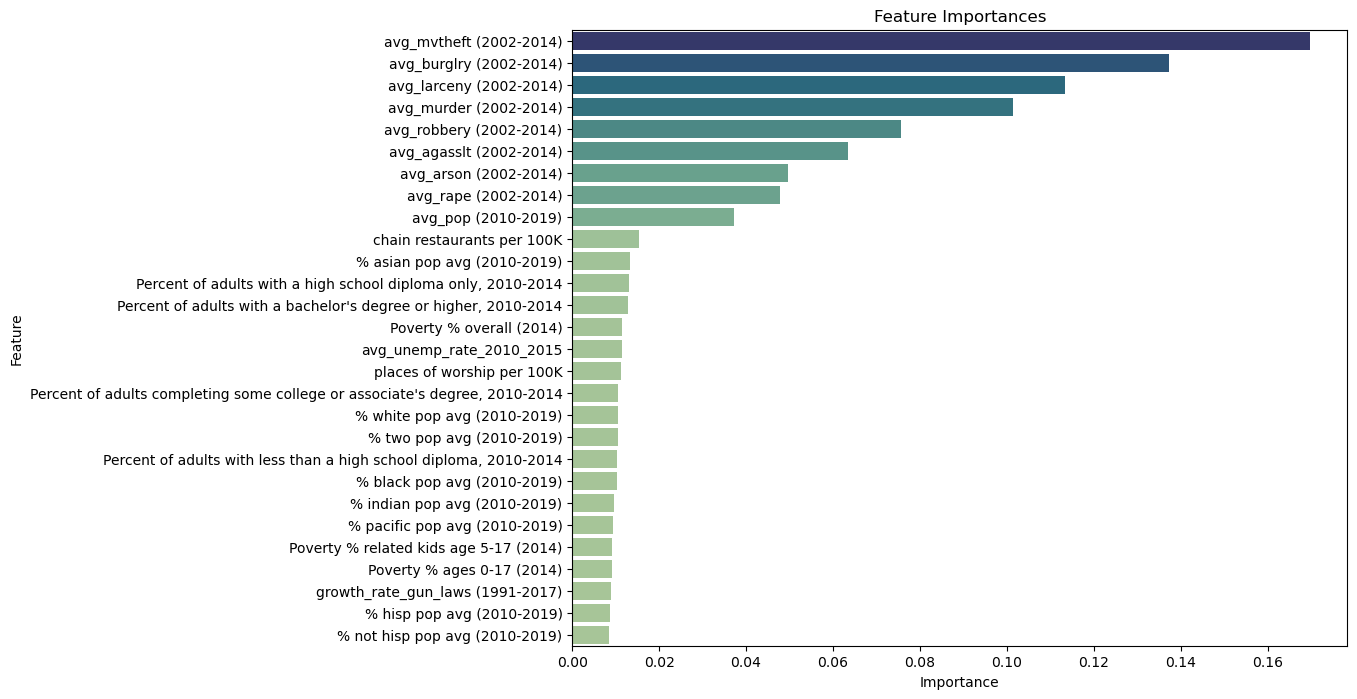

In [18]:
# Calculate feature importances
importances = rf_model.feature_importances_

# Convert feature importances into a pandas DataFrame
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True), columns=['Importance', 'Feature'])

# Normalize the importance scores to a 0-1 range
normalized = (importances_df['Importance'] - importances_df['Importance'].min()) / (importances_df['Importance'].max() - importances_df['Importance'].min())

# Plot the DataFrame using Seaborn
plt.figure(figsize=(10,8))
sns.barplot(y='Feature', x='Importance', data=importances_df, palette=sns.color_palette("crest", as_cmap=True)(normalized))
plt.title('Feature Importances')

# Save the figure
plt.savefig('../Output/figs/death_by_gun_occurs_gt1_rf.png', bbox_inches='tight')

# Show the plot
plt.show()


## Based on the binary model, calculate all probabilites for each county
## The probability a death by gun occurs in a county for a given year

In [19]:
# Add probabilities column to 'counties_gvd' and create new dataframe 'counties_gvd_prob'

# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale the data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = rf_model.predict_proba(X_all_scaled)[:, 1]  # probabilities for the positive outcome is usually at index 1

# Create a new dataframe
counties_gvd_prob = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob.to_csv('../Output/counties_gvd_prob.csv', index=False)


# Display the first few rows of the DataFrame
display(counties_gvd_prob.sample(10))
print("Total number of rows in counties_gvd_prob:", counties_gvd_prob.shape[0])


county_Abbr  county_code         state         Area name  \
3083   Campbell, WY - 56005        56005       Wyoming   Campbell County   
1680  Jefferson, NE - 31095        31095      Nebraska  Jefferson County   
1545     Platte, MO - 29165        29165      Missouri     Platte County   
1228      Clare, MI - 26035        26035      Michigan      Clare County   
2260     McKean, PA - 42083        42083  Pennsylvania     McKean County   
128       Greene, AR - 5055         5055      Arkansas     Greene County   
2116   Cherokee, OK - 40021        40021      Oklahoma   Cherokee County   
303      Tolland, CT - 9013         9013   Connecticut    Tolland County   
1219        Bay, MI - 26017        26017      Michigan        Bay County   
1391  Claiborne, MS - 28021        28021   Mississippi  Claiborne County   

         county Abbr  deaths_per_100K_mean (1999-2020)  \
3083   Campbell   WY                         24.194667   
1680  Jefferson   NE                          0.000000   
1545     Platte   MO                         15.123714   
1228      Clare   MI                         32.513000   
2260     McKean   PA                          0.000000   
128      Greene   AR                         26.350571   
2116   Cherokee   OK                         23.270500   
303     Tolland   CT                          7.439750   
1219        Bay   MI                         11.526462   
1391  Claiborne   MS                          0.000000   

      deaths_per_100K_std (1999-2020)  deaths_per_100K_numb_years (1999-2020)  \
3083                         3.495218                                     3.0   
1680                         0.000000                                     0.0   
1545                         3.190703                                     7.0   
1228                         0.000000                                     1.0   
2260                         0.000000                                     0.0   
128                          2.942256                                     7.0   
2116                         2.480123                                     4.0   
303                          1.002751                                     4.0   
1219                         2.239314                                    13.0   
1391                         0.000000                                     0.0   

      growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
3083                          1.098901             47205.02   
1680                          0.854701            127942.76   
1545                         -2.403846             45970.03   
1228                         -0.480769             30730.60   
2260                          4.298643             42219.10   
128                          -1.025641             55928.74   
2116                         -0.384615             59561.80   
303                           8.831909            151649.40   
1219                         -0.480769            141468.40   
1391                         -1.442308             20521.65   

      avg_murder (2002-2014)  avg_rape (2002-2014)  avg_robbery (2002-2014)  \
3083                0.538462              7.000000                 3.230769   
1680                0.230769              2.384615                 0.076923   
1545                6.076923             23.153846               114.000000   
1228                0.538462             22.769231                 3.153846   
2260                0.538462             12.615385                 3.461538   
128                 0.692308             17.923077                10.153846   
2116                1.692308             14.615385                 8.769231   
303                 0.615385             11.538462                15.692308   
1219                1.923077             77.230769                48.000000   
1391                1.615385              2.461538                 5.923077   

      avg_agasslt (2002-2014)  avg_burglry (2002-2014)  \
3083                62.230

Total number of rows in counties_gvd_prob: 3104


In [20]:
counties_gvd_prob['death_probability'].describe()

count    3104.000000
mean        0.412106
std         0.436519
min         0.000000
25%         0.008000
50%         0.139000
75%         0.958500
max         1.000000
Name: death_probability, dtype: float64

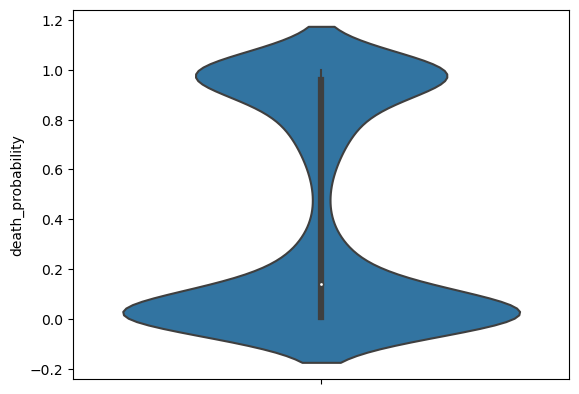

In [21]:
# construct a violin plot to see the distribution of values across the various probabilities

sns.violinplot(y='death_probability', data=counties_gvd_prob)
plt.show()

## Create a Folium Map

In [23]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename

# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob[counties_gvd_prob['death_probability'] <= 0.2]
prob2_df = counties_gvd_prob[(counties_gvd_prob['death_probability'] > 0.2) & (counties_gvd_prob['death_probability'] <= 0.8)]
prob3_df = counties_gvd_prob[counties_gvd_prob['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.2')
prob2 = MarkerCluster(name='Death Probability: 0.2-0.8')
prob3 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)
prob3_df.apply(add_marker, axis=1, cluster=prob3)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.2", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.2 - 0.8", show=False).add_child(prob2).add_to(m)
group3 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob3).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt1_rf.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:39<00:00, 1.05MB/s]


----------------------------------------------------------------------------------------------------

## Constructing a random forest model (binary, if deaths <= 14 return '0', deaths > 14 return '1' 

In [24]:
# create a copy of counties_gvd
copy_counties2 = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties2
# Convert the target variable to binary, '0' for no deaths, all else, '1'
X['deaths_occurred_gt14'] = (X['deaths_per_100K_mean (1999-2020)'] > 14).astype(int)

# Define the target
y = X['deaths_occurred_gt14']

# Define features set
X.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt14', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))





Confusion Matrix


Predicted 0  Predicted 1
Actual 0          525           41
Actual 1           73          137

Accuracy Score : 0.8530927835051546
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       566
           1       0.77      0.65      0.71       210

    accuracy                           0.85       776
   macro avg       0.82      0.79      0.80       776
weighted avg       0.85      0.85      0.85       776



## Feature importance of binary random forest model for 8 or more gun deaths per county

In [25]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.10025211390308679, 'avg_mvtheft (2002-2014)'),
 (0.07906425582410234, 'avg_larceny (2002-2014)'),
 (0.07069858098275413, 'avg_burglry (2002-2014)'),
 (0.058553539949591255, 'avg_murder (2002-2014)'),
 (0.05007806556680152, 'avg_pop (2010-2019)'),
 (0.04506861102325745, 'avg_robbery (2002-2014)'),
 (0.043447427198796, 'avg_rape (2002-2014)'),
 (0.03899906352233671, 'avg_agasslt (2002-2014)'),
 (0.03762064221132494, 'Poverty % ages 0-17 (2014)'),
 (0.03687576293244644, 'avg_arson (2002-2014)'),
 (0.035201854978221106, 'Poverty % related kids age 5-17 (2014)'),
 (0.03314144236526482, 'Poverty % overall (2014)'),
 (0.030726743484703032,
  "Percent of adults with a bachelor's degree or higher, 2010-2014"),
 (0.02910683187540216,
  'Percent of adults with less than a high school diploma, 2010-2014'),
 (0.028734775393923512, 'growth_rate_gun_laws (1991-2017)'),
 (0.027722906588587674, '% asian pop avg (2010-2019)'),
 (0.024766735362705915, '% black pop avg (2010-2019)'),
 (0.0236457040128

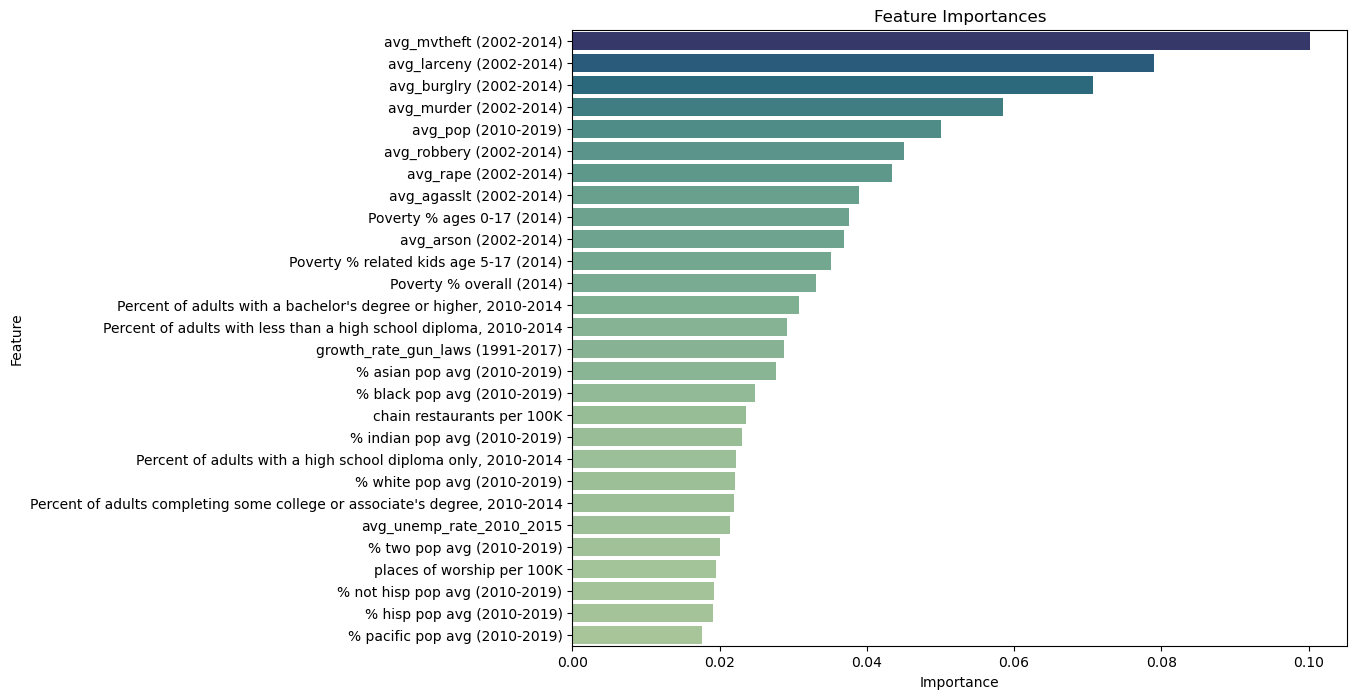

In [26]:
# Calculate feature importances
importances = rf_model.feature_importances_

# Convert feature importances into a pandas DataFrame
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True), columns=['Importance', 'Feature'])

# Normalize the importance scores to a 0-1 range
normalized = (importances_df['Importance'] - importances_df['Importance'].min()) / (importances_df['Importance'].max() - importances_df['Importance'].min())

# Plot the DataFrame using Seaborn
plt.figure(figsize=(10,8))
sns.barplot(y='Feature', x='Importance', data=importances_df, palette=sns.color_palette("crest", as_cmap=True)(normalized))
plt.title('Feature Importances')

# Save the figure
plt.savefig('../Output/figs/death_by_gun_gt14.png', bbox_inches='tight')

# Show the plot
plt.show()


## Based on the binary model, calculate all probabilites for each county
## The probability that at least 14 deaths by gun occur in a county per year

In [27]:
# Add probabilities column to 'counties_gvd' and create new dataframe 'counties_gvd_prob'

# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale the data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = rf_model.predict_proba(X_all_scaled)[:, 1]  # probabilities for the positive outcome is usually at index 1

# Create a new dataframe
counties_gvd_prob_gt14 = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob_gt14['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob_gt14.to_csv('../Output/counties_gvd_prob_gt14.csv', index=False)


# Display the first few rows of the DataFrame
display(counties_gvd_prob_gt14.sample(10))
print("Total number of rows in counties_gvd_prob_gt14:", counties_gvd_prob_gt14.shape[0])


county_Abbr  county_code       state  \
422                  Early, GA - 13099        13099     Georgia   
463                   Long, GA - 13183        13183     Georgia   
1073             Robertson, KY - 21201        21201    Kentucky   
1775                Colfax, NM - 35007        35007  New Mexico   
500                Stewart, GA - 13259        13259     Georgia   
2616             Jefferson, TX - 48245        48245       Texas   
2723                Walker, TX - 48471        48471       Texas   
1302               Carlton, MN - 27017        27017   Minnesota   
2880  Charlottesville City, VA - 51540        51540    Virginia   
2468                 Perry, TN - 47135        47135   Tennessee   

                 Area name                county Abbr  \
422           Early County                 Early   GA   
463            Long County                  Long   GA   
1073      Robertson County             Robertson   KY   
1775         Colfax County                Colfax   NM   
500         Stewart County               Stewart   GA   
2616      Jefferson County             Jefferson   TX   
2723         Walker County                Walker   TX   
1302        Carlton County               Carlton   MN   
2880  Charlottesville city  Charlottesville City   VA   
2468          Perry County                 Perry   TN   

      deaths_per_100K_mean (1999-2020)  deaths_per_100K_std (1999-2020)  \
422                           0.000000                         0.000000   
463                           0.000000                         0.000000   
1073                          0.000000                         0.000000   
1775                          0.000000                         0.000000   
500                           0.000000                         0.000000   
2616                         14.725318                         3.198682   
2723                         18.141000                         2.349009   
1302                          0.000000                         0.000000   
2880                          0.000000                         0.000000   
2468                          0.000000                         0.000000   

      deaths_per_100K_numb_years (1999-2020)  \
422                                      0.0   
463                                      0.0   
1073                                     0.0   
1775                                     0.0   
500                                      0.0   
2616                                    22.0   
2723                                     2.0   
1302                                     0.0   
2880                                     0.0   
2468                                     0.0   

      growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
422                          -1.923077             10498.90   
463                          -1.923077             17251.90   
1073                         -0.480769             29203.23   
1775                          0.000000             11677.45   
500                          -1.923077              9731.05   
2616                          1.479290            127942.76   
2723                          1.479290             68193.20   
1302                          6.666667             35490.90   
2880                          0.320513             45782.50   
2468                          0.854701             20941.49   

      avg_murder (2002-2014)  avg_rape (2002-2014)  avg_robbery (2002-2014)  \
422                 0.769231              4.000000                 7.461538   
463                 0.384615              4.076923                 5.000000   
1073                0.000000              0.000000                 0.000000   
1775                0.384615              2.615385                 2.692308   
500                 0.230769              0.461538                 3.384615   
2616               19.538462            128.461538               528.923077   
2723                1.923077             27.692308         

Total number of rows in counties_gvd_prob_gt14: 3104


In [28]:
counties_gvd_prob_gt14['death_probability'].describe()

count    3104.000000
mean        0.255373
std         0.337969
min         0.000000
25%         0.006000
50%         0.070000
75%         0.468500
max         0.998000
Name: death_probability, dtype: float64

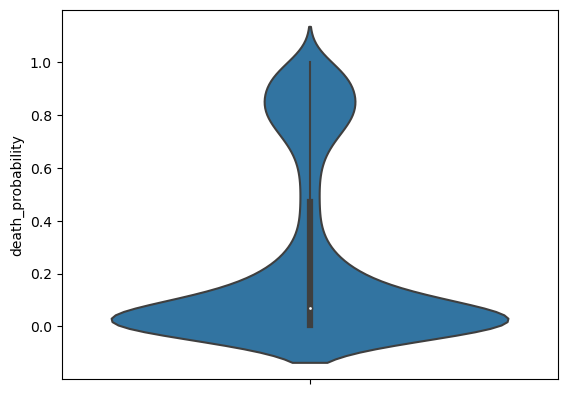

In [29]:
# construct a violin plot to see the distribution of values across the various probabilities

sns.violinplot(y='death_probability', data=counties_gvd_prob_gt14)
plt.show()

## Create a Folium Map

In [30]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename

# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob_gt14[counties_gvd_prob_gt14['death_probability'] <= 0.8]
prob2_df = counties_gvd_prob_gt14[counties_gvd_prob_gt14['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.8')
prob2 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.8", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob2).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt14_rf.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:14<00:00, 1.40MB/s]


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## Tune & create a neural network model (binary, if deaths occur (1) or did not occur (0) for a given county

In [31]:
# create a copy of counties_gvd
copy_counties = counties_gvd.copy()

# Convert the target variable to binary, '0' for no deaths, all else, '1'
X = copy_counties
X['deaths_occurred_gt1'] = (X['deaths_per_100K_mean (1999-2020)'] != 0).astype(int)

# Define the target
y = X['deaths_occurred_gt1']

# Define features set
X.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'deaths_occurred_gt1', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','swish'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=X_train_scaled.shape[1])) # This code 'input_dim=X_train_scaled.shape[1]' indicates the shape of the dataset

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

import datetime # this ensures that a new folder will be made for every run of this code
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Create a `Hyperband()` tuner instance
directory_path = '/Users/a/Desktop/GVD_Data/hyberband_results'
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=40,
    hyperband_iterations=2,
    directory=f'{directory_path}/hyperband_{current_time}',
    project_name='keras_tuner')

# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=40,validation_data=(X_test_scaled,y_test))

# View the results
tuner.results_summary()


Trial 180 Complete [00h 00m 32s]
val_accuracy: 0.8956185579299927

Best val_accuracy So Far: 0.9033505320549011
Total elapsed time: 00h 23m 50s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /Users/a/Desktop/GVD_Data/hyberband_results/hyperband_20230531-162729/keras_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0082 summary
Hyperparameters:
activation: swish
first_units: 3
num_layers: 4
units_0: 9
units_1: 1
units_2: 1
units_3: 7
units_4: 9
units_5: 5
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080
Score: 0.9033505320549011

Trial 0051 summary
Hyperparameters:
activation: swish
first_units: 9
num_layers: 3
units_0: 7
units_1: 1
units_2: 7
units_3: 7
units_4: 9
units_5: 3
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.9020618796348572

Trial 0174 summary
Hyperparameters:
activation: swish
first_units: 9
num_layers: 4
units_0: 5
uni

In [32]:
# Create a Keras Sequential model
nn_model = tf.keras.models.Sequential()

# First layer with input dimension and "swish" activation function
nn_model.add(tf.keras.layers.Dense(units=3, activation="swish", input_dim=X_train_scaled.shape[1]))

# Add more layers according to the best hyperparameters found
nn_model.add(tf.keras.layers.Dense(units=9, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="swish"))
nn_model.add(tf.keras.layers.Dense(units=7, activation="swish"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 3)                 87        
                                                                 
 dense_8 (Dense)             (None, 9)                 36        
                                                                 
 dense_9 (Dense)             (None, 1)                 10        
                                                                 
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
 dense_11 (Dense)            (None, 7)                 14        
                                                                 
 dense_12 (Dense)            (None, 1)                 8         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable 

In [33]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model, and include the early stopping callback in the fit() method's callbacks parameter
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=200, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])


Epoch 1/200
73/73 [==============================] - 4s 40ms/step - loss: 0.6852 - accuracy: 0.5846 - val_loss: 0.6778 - val_accuracy: 0.5941
Epoch 2/200
73/73 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.6057 - val_loss: 0.6648 - val_accuracy: 0.6031
Epoch 3/200
73/73 [==============================] - 1s 10ms/step - loss: 0.6468 - accuracy: 0.6353 - val_loss: 0.6319 - val_accuracy: 0.6534
Epoch 4/200
73/73 [==============================] - 1s 9ms/step - loss: 0.5846 - accuracy: 0.7259 - val_loss: 0.5733 - val_accuracy: 0.7320
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.5207 - accuracy: 0.7719 - val_loss: 0.5263 - val_accuracy: 0.7719
Epoch 6/200
73/73 [==============================] - 1s 9ms/step - loss: 0.4715 - accuracy: 0.8050 - val_loss: 0.4884 - val_accuracy: 0.7809
Epoch 7/200
73/73 [==============================] - 1s 9ms/step - loss: 0.4290 - accuracy: 0.8213 - val_loss: 0.4558 - val_accuracy: 0.8093
Epoch 8/20

Epoch 59/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2287 - accuracy: 0.8973 - val_loss: 0.2560 - val_accuracy: 0.8995
Epoch 60/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2271 - accuracy: 0.8991 - val_loss: 0.2602 - val_accuracy: 0.9046
Epoch 61/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2268 - accuracy: 0.8969 - val_loss: 0.2561 - val_accuracy: 0.9034
Epoch 62/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2263 - accuracy: 0.8991 - val_loss: 0.2528 - val_accuracy: 0.8982
Epoch 63/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2267 - accuracy: 0.8982 - val_loss: 0.2545 - val_accuracy: 0.9034
Epoch 64/200
73/73 [==============================] - 1s 7ms/step - loss: 0.2260 - accuracy: 0.9038 - val_loss: 0.2566 - val_accuracy: 0.8995
Epoch 65/200
73/73 [==============================] - 1s 8ms/step - loss: 0.2266 - accuracy: 0.8978 - val_loss: 0.2529 - val_accuracy: 0.8982
Epoch 

In [36]:
# Making predictions using the testing data
predictions_proba = nn_model.predict(X_test_scaled)
predictions = np.round(predictions_proba).astype(int) # rounding off the probabilities and converting to integers

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

25/25 [==============================] - 0s 2ms/step
Confusion Matrix


Predicted 0  Predicted 1
Actual 0          426           23
Actual 1           45          282

Accuracy Score : 0.9123711340206185
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       449
           1       0.92      0.86      0.89       327

    accuracy                           0.91       776
   macro avg       0.91      0.91      0.91       776
weighted avg       0.91      0.91      0.91       776



In [37]:
# Copy dataframe and drop unnecessary columns
X_all = counties_gvd.copy()
X_all.drop(['county_Abbr', 'county_code', 'state', 'Area name', 'county', 'Abbr', 'deaths_per_100K_mean (1999-2020)', 'deaths_per_100K_std (1999-2020)', 'deaths_per_100K_numb_years (1999-2020)', 'name', 'lng', 'lat'], axis=1, inplace=True)

# Scale all data
X_all_scaled = X_scaler.transform(X_all)

# Use the model to predict the probability of death for all data
death_probabilities = nn_model.predict(X_all_scaled)[:, 0]  # probabilities for the positive outcome is at index 0 for a neural network with sigmoid output

# Create a new dataframe
counties_gvd_prob_nn = counties_gvd.copy()

# Add the probabilities as a new column in your new DataFrame
counties_gvd_prob_nn['death_probability'] = death_probabilities

# Create a CSV of 'counties_gvd_prob'
counties_gvd_prob_nn.to_csv('../Output/counties_gvd_prob_nn.csv', index=False)

# Display the first few rows of the DataFrame
display(counties_gvd_prob_nn.sample(10))
print("Total number of rows in counties_gvd_prob_nn:", counties_gvd_prob_nn.shape[0])


97/97 [==============================] - 0s 2ms/step


county_Abbr  county_code        state  \
1448    Tallahatchie, MS - 28135        28135  Mississippi   
881             Clay, KS - 20027        20027       Kansas   
1154    West Carroll, LA - 22123        22123    Louisiana   
1646           Cedar, NE - 31027        31027     Nebraska   
2894  Lexington City, VA - 51678        51678     Virginia   
3009           Adams, WI - 55001        55001    Wisconsin   
1315       Faribault, MN - 27043        27043    Minnesota   
2563         Edwards, TX - 48137        48137        Texas   
1553          Ripley, MO - 29181        29181     Missouri   
1735        Pershing, NV - 32027        32027       Nevada   

                Area name          county Abbr  \
1448  Tallahatchie County    Tallahatchie   MS   
881           Clay County            Clay   KS   
1154  West Carroll Parish    West Carroll   LA   
1646         Cedar County           Cedar   NE   
2894       Lexington city  Lexington City   VA   
3009         Adams County           Adams   WI   
1315     Faribault County       Faribault   MN   
2563       Edwards County         Edwards   TX   
1553        Ripley County          Ripley   MO   
1735      Pershing County        Pershing   NV   

      deaths_per_100K_mean (1999-2020)  deaths_per_100K_std (1999-2020)  \
1448                               0.0                              0.0   
881                                0.0                              0.0   
1154                               0.0                              0.0   
1646                               0.0                              0.0   
2894                               0.0                              0.0   
3009                               0.0                              0.0   
1315                               0.0                              0.0   
2563                               0.0                              0.0   
1553                               0.0                              0.0   
1735                               0.0                              0.0   

      deaths_per_100K_numb_years (1999-2020)  \
1448                                     0.0   
881                                      0.0   
1154                                     0.0   
1646                                     0.0   
2894                                     0.0   
3009                                     0.0   
1315                                     0.0   
2563                                     0.0   
1553                                     0.0   
1735                                     0.0   

      growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
1448                         -1.442308             14611.80   
881                          -1.775148             38619.13   
1154                          0.769231             11280.60   
1646                          0.854701             13649.10   
2894                          0.320513              7151.00   
3009                          1.682692             68907.97   
1315                          6.666667             14039.90   
2563                          1.479290              3814.07   
1553                         -2.403846             21126.10   
1735                          6.250000              6673.10   

      avg_murder (2002-2014)  avg_rape (2002-2014)  avg_robbery (2002-2014)  \
1448                0.230769              0.615385                 9.923077   
881                 0.230769              4.230769                 0.461538   
1154                0.461538              0.461538                 0.538462   
1646                0.076923              0.153846                 0.153846   
2894                0.000000              0.692308                 1.384615   
3009                0.153846              4.153846                 1.384615   
1315                0.230769              3.153846                 0.153846   
2563                0.076923              0.153846                 0.153846   
1553                0.69230

Total number of rows in counties_gvd_prob_nn: 3104


## Create a folium map for the neural network model

In [38]:
# Path to the GeoJSON file
file_id = '1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a'
filename = os.path.join('/Users/a/Desktop/GVD_Data', 'georef-united-states-of-america-county.geojson')
gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)

geojson_path = filename


# Create a Map instance
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add GeoJSON layer
folium.GeoJson(
    geojson_path,
    name='US Counties',
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.4,
        'dashArray': '5, 5'
    }
).add_to(m)

# Define different dataframes
prob1_df = counties_gvd_prob_nn[counties_gvd_prob_nn['death_probability'] <= 0.8]
prob2_df = counties_gvd_prob_nn[counties_gvd_prob_nn['death_probability'] > 0.8]

# Create MarkerClusters
prob1 = MarkerCluster(name='Death Probability: 0.0-0.8')
prob2 = MarkerCluster(name='Death Probability: 0.8-1.0')

# Function to add markers
def add_marker(row, cluster):
    folium.Marker(
        [row['lat'], row['lng']], 
        tooltip=f"{row['county']}, {row['state']}<br>Probability of death by gun: <b>{row['death_probability']:.3f}</b>",
        popup=folium.Popup(f"Average Unemp. rate: <b>{round(row['avg_unemp_rate_2010_2015'], 2)}</b><br>"
                           f"Number of chain restaurants per 100,000 persons: <b>{round(row['chain restaurants per 100K'], 2)}</b><br>"
                           f"Number of places of worship per 100,000 persons: <b>{round(row['places of worship per 100K'], 2)}</b><br>"
                           f"Gun law growth rate from 1991-2017: <b>{round(row['growth_rate_gun_laws (1991-2017)'], 2)}</b>", max_width=300)
    ).add_to(cluster)

# Apply function to each row in the dataframes
prob1_df.apply(add_marker, axis=1, cluster=prob1)
prob2_df.apply(add_marker, axis=1, cluster=prob2)

# Create FeatureGroups for the different probabilities and add them to the map
group1 = folium.FeatureGroup(name="Probability: 0.0 - 0.8", show=False).add_child(prob1).add_to(m)
group2 = folium.FeatureGroup(name="Probability: 0.8 - 1.0", show=False).add_child(prob2).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save it as html
m.save('/Users/a/Desktop/GVD_Data/Maps/binary_map_gt1_nn.html')


Downloading...
From: https://drive.google.com/uc?id=1LVRmvcdO3o_M_tHa1DiYbHWpXgUL_e_a
To: /Users/a/Desktop/GVD_Data/georef-united-states-of-america-county.geojson
100%|████████████████████████████████████████| 104M/104M [01:29<00:00, 1.17MB/s]


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## Start Clustering analysis

## Clustering based on Poverty Data

In [42]:
# create a dataframe based on the poverty data
poverty_df = counties_gvd[['county_Abbr', 'Poverty % overall (2014)', 'Poverty % ages 0-17 (2014)', 'Poverty % related kids age 5-17 (2014)']]

# Setting 'county_Abbr' as index
poverty_df = poverty_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
poverty_data_scaled = StandardScaler().fit_transform(poverty_df[
    ['Poverty % overall (2014)', 
     'Poverty % ages 0-17 (2014)',
     'Poverty % related kids age 5-17 (2014)']
])

# Create a DataFrame with the scaled data
df_poverty_data_scaled = pd.DataFrame(poverty_data_scaled, columns=['Poverty % overall (2014)', 
     "Poverty % ages 0-17 (2014)",
     "Poverty % related kids age 5-17 (2014)"
])

# Copy the county_abbr names from the original data
df_poverty_data_scaled["county_Abbr"] = poverty_df.index

# Set the county_abbr column as index
df_poverty_data_scaled = df_poverty_data_scaled.set_index('county_Abbr')



# Display sample data
df_poverty_data_scaled.head()



Poverty % overall (2014)  Poverty % ages 0-17 (2014)  \
county_Abbr                                                                
Autauga, AL - 1001                 -0.584284                   -0.625340   
Baldwin, AL - 1003                 -0.599874                   -0.434556   
Barbour, AL - 1005                  1.333256                    1.619174   
Bibb, AL - 1007                     0.195203                    0.351023   
Blount, AL - 1009                   0.101665                    0.048014   

                    Poverty % related kids age 5-17 (2014)  
county_Abbr                                                 
Autauga, AL - 1001                               -0.542127  
Baldwin, AL - 1003                               -0.391402  
Barbour, AL - 1005                                1.730341  
Bibb, AL - 1007                                   0.362222  
Blount, AL - 1009                                 0.049178

### Find the Best Value for k Using the Original Data.

In [43]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_poverty_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_poverty_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

### Cluster Poverty Data with K-means Using the Original Data

In [44]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_poverty_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_poverty_data_scaled)

# Create a copy of the DataFrame
poverty_scaled_predictions = df_poverty_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
poverty_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="Poverty % overall (2014)"` and `y="Poverty % ages 0-17 (2014)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = poverty_scaled_predictions.hvplot.scatter(
    x="Poverty % overall (2014)",
    y="Poverty % ages 0-17 (2014)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Poverty Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [Poverty % overall (2014)]   (Poverty % ages 0-17 (2014),county_Abbr)

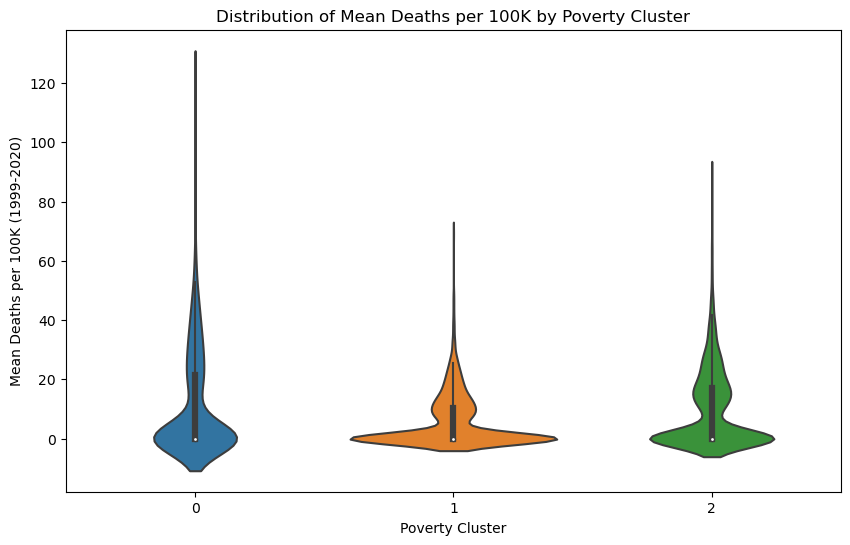

In [45]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    poverty_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'poverty_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'poverty_cluster'}, inplace=True)

# construct a violin plot relating poverty clustering and 

plt.figure(figsize=(10, 6))
sns.violinplot(x='poverty_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Poverty Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Poverty Cluster')

plt.show()



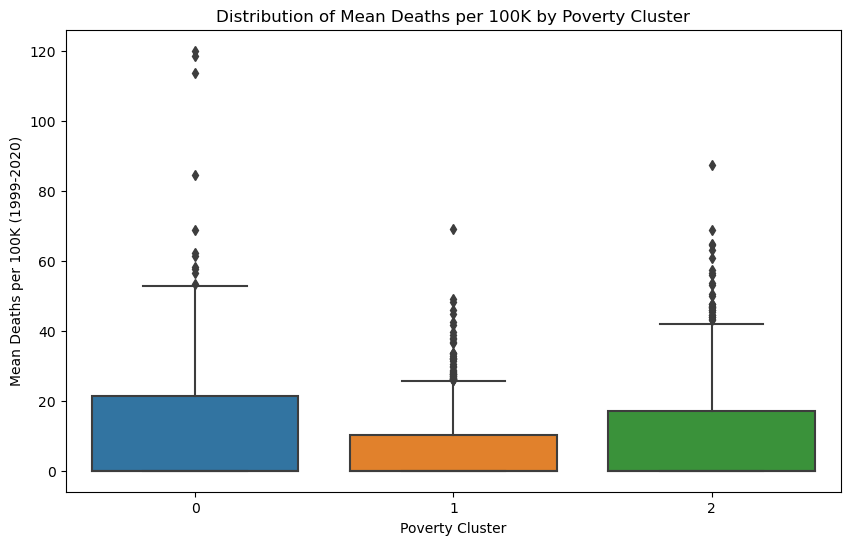

In [46]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='poverty_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Poverty Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Poverty Cluster')

plt.show()

## Clustering based on Crime Data

In [47]:
# create a dataframe based on the poverty data
crime_df = counties_gvd[['county_Abbr', 'avg_murder (2002-2014)' , 'avg_rape (2002-2014)','avg_robbery (2002-2014)','avg_agasslt (2002-2014)','avg_burglry (2002-2014)','avg_larceny (2002-2014)','avg_mvtheft (2002-2014)','avg_arson (2002-2014)']]

# Setting 'county_Abbr' as index
crime_df = crime_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
crime_data_scaled = StandardScaler().fit_transform(crime_df[
    ['avg_murder (2002-2014)',
     'avg_rape (2002-2014)',
     'avg_robbery (2002-2014)',
     'avg_agasslt (2002-2014)',
     'avg_burglry (2002-2014)',
     'avg_larceny (2002-2014)',
     'avg_mvtheft (2002-2014)',
     'avg_arson (2002-2014)']
])

# Create a DataFrame with the scaled data
df_crime_data_scaled = pd.DataFrame(crime_data_scaled, columns=['avg_murder (2002-2014)',
     'avg_rape (2002-2014)',
     'avg_robbery (2002-2014)',
     'avg_agasslt (2002-2014)',
     'avg_burglry (2002-2014)',
     'avg_larceny (2002-2014)',
     'avg_mvtheft (2002-2014)',
     'avg_arson (2002-2014)'
])

# Copy the county_abbr names from the original data
df_crime_data_scaled["county_Abbr"] = crime_df.index

# Set the county_abbr column as index
df_crime_data_scaled = df_crime_data_scaled.set_index('county_Abbr')



# Display sample data
df_crime_data_scaled.head()



avg_murder (2002-2014)  avg_rape (2002-2014)  \
county_Abbr                                                        
Autauga, AL - 1001               -0.139135             -0.111942   
Baldwin, AL - 1003               -0.024982              0.172695   
Barbour, AL - 1005               -0.166171             -0.260911   
Bibb, AL - 1007                  -0.178187             -0.291059   
Blount, AL - 1009                -0.166171             -0.215688   

                    avg_robbery (2002-2014)  avg_agasslt (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001                -0.118977                -0.153697   
Baldwin, AL - 1003                -0.083106                -0.016340   
Barbour, AL - 1005                -0.149766                -0.202697   
Bibb, AL - 1007                   -0.157286                -0.204482   
Blount, AL - 1009                 -0.157387                -0.180554   

                    avg_burglry (2002-2014)  avg_larceny (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001                -0.142305                -0.123893   
Baldwin, AL - 1003                 0.063134                 0.141642   
Barbour, AL - 1005                -0.249691                -0.245229   
Bibb, AL - 1007                   -0.252304                -0.269217   
Blount, AL - 1009                 -0.172919                -0.205907   

                    avg_mvtheft (2002-2014)  avg_arson (2002-2014)  
county_Abbr                                                         
Autauga, AL - 1001                -0.120170              -0.067836  
Baldwin, AL - 1003                -0.084631              -0.149135  
Barbour, AL - 1005                -0.166838              -0.217179  
Bibb, AL - 1007                   -0.165968              -0.218946  
Blount, AL - 1009                 -0.133177              -0.193319

### Find the Best Value for k Using the Original Data.

In [48]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_crime_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_crime_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

## Cluster Crime Data with K-means Using the Original Data

In [49]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_crime_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_crime_data_scaled)

# Create a copy of the DataFrame
crime_scaled_predictions = df_crime_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
crime_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="avg_murder (2002-2014)"` and `y="avg_rape (2002-2014)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = crime_scaled_predictions.hvplot.scatter(
    x="avg_murder (2002-2014)",
    y="avg_rape (2002-2014)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Crime Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [avg_murder (2002-2014)]   (avg_rape (2002-2014),county_Abbr)

In [50]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    crime_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'crime_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'crime_cluster'}, inplace=True)

# view the dataframe
counties_gvd_copy.head()



index  county_code    state       Area name   county Abbr  \
county_Abbr                                                                     
Autauga, AL - 1001      0         1001  Alabama  Autauga County  Autauga   AL   
Baldwin, AL - 1003      1         1003  Alabama  Baldwin County  Baldwin   AL   
Barbour, AL - 1005      2         1005  Alabama  Barbour County  Barbour   AL   
Bibb, AL - 1007         3         1007  Alabama     Bibb County     Bibb   AL   
Blount, AL - 1009       4         1009  Alabama   Blount County   Blount   AL   

                    deaths_per_100K_mean (1999-2020)  \
county_Abbr                                            
Autauga, AL - 1001                         21.971571   
Baldwin, AL - 1003                         13.911000   
Barbour, AL - 1005                          0.000000   
Bibb, AL - 1007                             0.000000   
Blount, AL - 1009                          20.789818   

                    deaths_per_100K_std (1999-2020)  \
county_Abbr                                           
Autauga, AL - 1001                         3.796015   
Baldwin, AL - 1003                         3.044843   
Barbour, AL - 1005                         0.000000   
Bibb, AL - 1007                            0.000000   
Blount, AL - 1009                          3.371535   

                    deaths_per_100K_numb_years (1999-2020)  \
county_Abbr                                                  
Autauga, AL - 1001                                     7.0   
Baldwin, AL - 1003                                    22.0   
Barbour, AL - 1005                                     0.0   
Bibb, AL - 1007                                        0.0   
Blount, AL - 1009                                     11.0   

                    growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
county_Abbr                                                                 
Autauga, AL - 1001                         -1.282051             55127.10   
Baldwin, AL - 1003                         -1.282051            123611.65   
Barbour, AL - 1005                         -1.282051             21472.95   
Bibb, AL - 1007                            -1.282051             88479.35   
Blount, AL - 1009                          -1.282051             92353.30   

                    avg_murder (2002-2014)  avg_rape (2002-2014)  \
county_Abbr                                                        
Autauga, AL - 1001                1.307692             18.307692   
Baldwin, AL - 1003                4.230769             43.000000   
Barbour, AL - 1005                0.615385              5.384615   
Bibb, AL - 1007                   0.307692              2.769231   
Blount, AL - 1009                 0.615385              9.307692   

                    avg_robbery (2002-2014)  avg_agasslt (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001                33.769231                87.538462   
Baldwin, AL - 1003                60.923077               235.461538   
Barbour, AL - 1005                10.461538                34.769231   
Bibb, AL - 1007                    4.769231                32.846154   
Blount, AL - 1009                  4.692308                58.615385   

                    avg_burglry (2002-2014)  avg_larceny (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001               332.230769              1161.538462   
Baldwin, AL - 1003               797.846154              2943.769231   
Barbour, AL - 1005                88.846154               347.153846   
Bibb, AL - 1007                   82.923077               186.153846   
Blount, AL - 1009                262.846154               611.076923   

                    avg_mvtheft (2002-2014)  avg_arson (2002-2014)  \
county_Abbr                                                          
Autauga, AL - 1001                99.153846              13.461538   
B

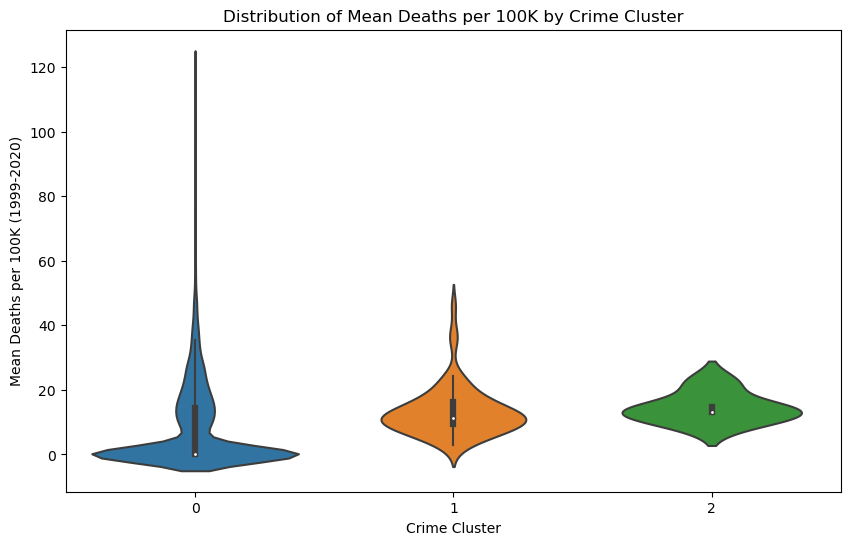

In [51]:
# construct a violin plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.violinplot(x='crime_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Crime Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()


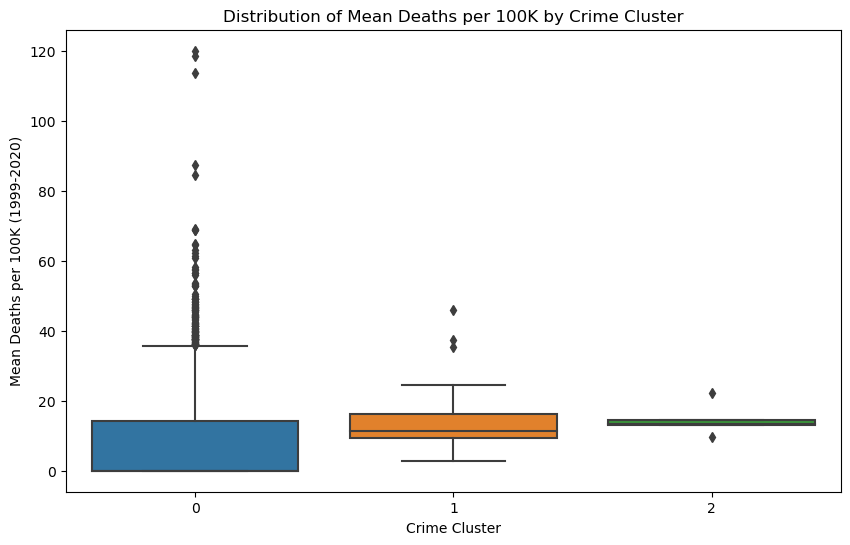

In [52]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='crime_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Crime Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()


## Clustering based on Race Data

In [53]:
# create a dataframe based on the poverty data
race_df = counties_gvd[['county_Abbr', '% white pop avg (2010-2019)','% black pop avg (2010-2019)','% asian pop avg (2010-2019)','% indian pop avg (2010-2019)','% pacific pop avg (2010-2019)','% two pop avg (2010-2019)']]

# Setting 'county_Abbr' as index
race_df = race_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
race_data_scaled = StandardScaler().fit_transform(race_df[
    ['% white pop avg (2010-2019)',
     '% black pop avg (2010-2019)',
     '% asian pop avg (2010-2019)',
     '% indian pop avg (2010-2019)',
     '% pacific pop avg (2010-2019)',
     '% two pop avg (2010-2019)']
])

# Create a DataFrame with the scaled data
df_race_data_scaled = pd.DataFrame(race_data_scaled, columns=['% white pop avg (2010-2019)',
                                                              '% black pop avg (2010-2019)',
                                                              '% asian pop avg (2010-2019)',
                                                              '% indian pop avg (2010-2019)',
                                                              '% pacific pop avg (2010-2019)',
                                                              '% two pop avg (2010-2019)'
])

# Copy the county_abbr names from the original data
df_race_data_scaled["county_Abbr"] = race_df.index

# Set the county_abbr column as index
df_race_data_scaled = df_race_data_scaled.set_index('county_Abbr')



# Display sample data
df_race_data_scaled.head()



% white pop avg (2010-2019)  % black pop avg (2010-2019)  \
county_Abbr                                                                    
Autauga, AL - 1001                    -0.430380                     0.686961   
Baldwin, AL - 1003                    -0.174637                     0.404389   
Barbour, AL - 1005                    -1.147294                     1.560450   
Bibb, AL - 1007                       -2.737635                     3.212605   
Blount, AL - 1009                      0.806493                    -0.621649   

                    % asian pop avg (2010-2019)  % indian pop avg (2010-2019)  \
county_Abbr                                                                     
Autauga, AL - 1001                    -0.290763                     -0.252584   
Baldwin, AL - 1003                    -0.291909                     -0.221090   
Barbour, AL - 1005                    -0.559218                     -0.235283   
Bibb, AL - 1007                       -0.033560                     -0.283262   
Blount, AL - 1009                     -0.442083                     -0.253243   

                    % pacific pop avg (2010-2019)  % two pop avg (2010-2019)  
county_Abbr                                                                   
Autauga, AL - 1001                      -0.130732                  -0.304680  
Baldwin, AL - 1003                      -0.302157                  -0.443637  
Barbour, AL - 1005                      -0.002373                  -0.763976  
Bibb, AL - 1007                          0.011846                  -0.642654  
Blount, AL - 1009                       -0.237603                  -0.520942

### Find the Best Value for k Using the Original Data.

In [54]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_race_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_race_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

### Cluster Poverty Data with K-means Using the Original Data

In [55]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_race_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_race_data_scaled)

# Create a copy of the DataFrame
race_scaled_predictions = df_race_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
race_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x="% white pop avg (2010-2019)"` and `y="% black pop avg (2010-2019)"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = race_scaled_predictions.hvplot.scatter(
    x="% white pop avg (2010-2019)",
    y="% black pop avg (2010-2019)",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Race Data Clusters"
)

orig_cluster


:NdOverlay   [kmeans_predictions]
   :Scatter   [% white pop avg (2010-2019)]   (% black pop avg (2010-2019),county_Abbr)

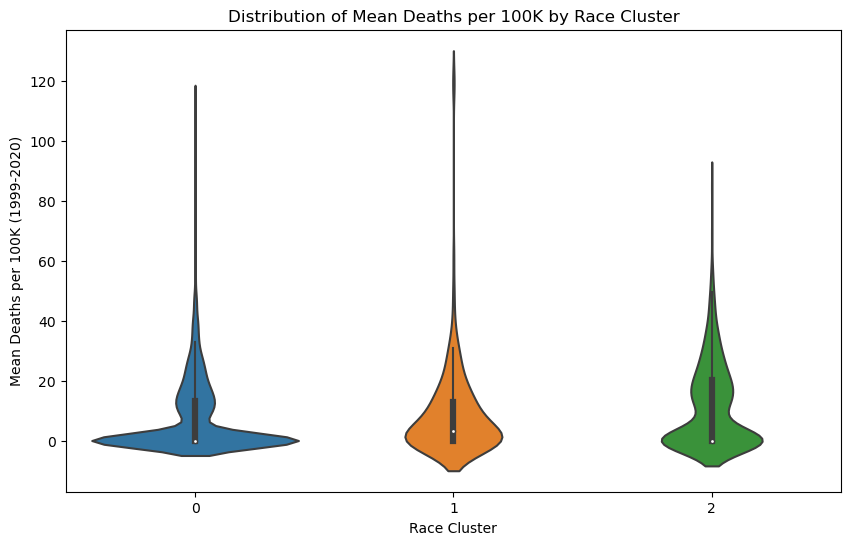

In [56]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    race_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'poverty_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'race_cluster'}, inplace=True)

# construct a violin plot relating poverty clustering and 

plt.figure(figsize=(10, 6))
sns.violinplot(x='race_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Race Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Race Cluster')

plt.show()

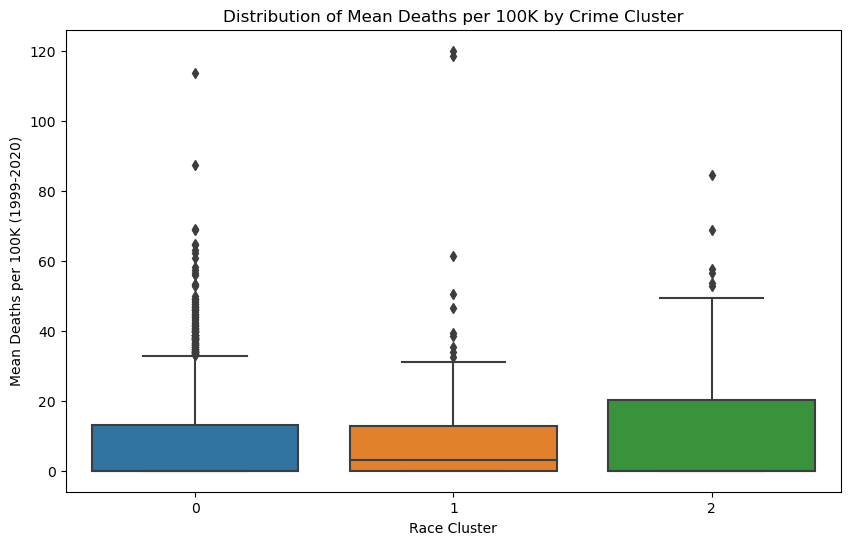

In [57]:
# construct a box plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='race_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Race Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Crime Cluster')

plt.show()

## Clustering based on Education Data

In [58]:
# create a dataframe based on the poverty data
educ_df = counties_gvd[['county_Abbr', 'Percent of adults with less than a high school diploma, 2010-2014','Percent of adults with a high school diploma only, 2010-2014' ,"Percent of adults completing some college or associate's degree, 2010-2014" ,"Percent of adults with a bachelor's degree or higher, 2010-2014"]]

# Setting 'county_Abbr' as index
educ_df = educ_df.set_index('county_Abbr')

# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
educ_data_scaled = StandardScaler().fit_transform(educ_df[
    ['Percent of adults with less than a high school diploma, 2010-2014',
     'Percent of adults with a high school diploma only, 2010-2014',
     "Percent of adults completing some college or associate's degree, 2010-2014",
     "Percent of adults with a bachelor's degree or higher, 2010-2014"]
])

# Create a DataFrame with the scaled data
df_educ_data_scaled = pd.DataFrame(educ_data_scaled, columns=[
    'Percent of adults with less than a high school diploma, 2010-2014',
    'Percent of adults with a high school diploma only, 2010-2014',
    "Percent of adults completing some college or associate's degree, 2010-2014",
    "Percent of adults with a bachelor's degree or higher, 2010-2014"
])

# Copy the county_abbr names from the original data
df_educ_data_scaled["county_Abbr"] = educ_df.index

# Set the county_abbr column as index
df_educ_data_scaled = df_educ_data_scaled.set_index('county_Abbr')



# Display sample data
df_educ_data_scaled.head()



Percent of adults with less than a high school diploma, 2010-2014  \
county_Abbr                                                                             
Autauga, AL - 1001                                          -0.177805                   
Baldwin, AL - 1003                                          -0.602443                   
Barbour, AL - 1005                                           1.540508                   
Bibb, AL - 1007                                              1.047170                   
Blount, AL - 1009                                            1.023027                   

                    Percent of adults with a high school diploma only, 2010-2014  \
county_Abbr                                                                        
Autauga, AL - 1001                                          -0.183844              
Baldwin, AL - 1003                                          -0.851879              
Barbour, AL - 1005                                          -0.191827              
Bibb, AL - 1007                                              0.751028              
Blount, AL - 1009                                           -0.042410              

                    Percent of adults completing some college or associate's degree, 2010-2014  \
county_Abbr                                                                                      
Autauga, AL - 1001                                           0.123301                            
Baldwin, AL - 1003                                           0.290349                            
Barbour, AL - 1005                                          -0.492214                            
Bibb, AL - 1007                                             -0.476801                            
Blount, AL - 1009                                            0.234822                            

                    Percent of adults with a bachelor's degree or higher, 2010-2014  
county_Abbr                                                                          
Autauga, AL - 1001                                           0.207598                
Baldwin, AL - 1003                                           0.958507                
Barbour, AL - 1005                                          -0.728841                
Bibb, AL - 1007                                             -1.107099                
Blount, AL - 1009                                           -0.879826

### Find the Best Value for k Using the Original Data.

In [59]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_educ_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(df_educ_data_scaled)
    inertia.append(k_model.inertia_)

    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

# differences between rows to get better assessment of best K value
df_elbow['inertia_diff'] = df_elbow['inertia'].diff()

# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_orig = df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve from original data", 
    xticks=k
)

elbow_orig



:Curve   [k]   (inertia)

## Cluster Education Data with K-means Using the Original Data

In [60]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means model using the scaled data
model.fit(df_educ_data_scaled)

# Predict the clusters to group the poverty data using the scaled data
kmeans_predictions = model.predict(df_educ_data_scaled)

# Create a copy of the DataFrame
educ_scaled_predictions = df_educ_data_scaled.copy()

# Add a new column to the DataFrame with the predicted clusters
educ_scaled_predictions['kmeans_predictions']=kmeans_predictions

# Create a scatter plot using hvPlot by setting 
# `x='Percent of adults with less than a high school diploma, 2010-2014"` and `y="Percent of adults with a high school diploma only, 2010-2014"`. 
# Color the graph points with the labels found using K-Means and 
# add the county_Abbr name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

orig_cluster = educ_scaled_predictions.hvplot.scatter(
    x="Percent of adults with less than a high school diploma, 2010-2014",
    y="Percent of adults with a high school diploma only, 2010-2014",
    by="kmeans_predictions",
    hover_cols=["county_Abbr"],
    title="Crime Data Clusters"
)

orig_cluster




:NdOverlay   [kmeans_predictions]
   :Scatter   [Percent of adults with less than a high school diploma, 2010-2014]   (Percent of adults with a high school diploma only, 2010-2014,county_Abbr)

In [61]:
# add the cluster labels to a copy of the 'counties_gvd'

# Make a copy of 'counties_gvd'
counties_gvd_copy = counties_gvd.copy()

# Add the predicted clusters to the copied DataFrame
counties_gvd_copy = counties_gvd_copy.reset_index().merge(
    educ_scaled_predictions[['kmeans_predictions']].reset_index(),
    how="left",
    on="county_Abbr"
).set_index('county_Abbr')


# rename 'kmeans_predictions' to 'educ_cluster'
counties_gvd_copy.rename(columns={'kmeans_predictions': 'educ_cluster'}, inplace=True)

# view the dataframe
counties_gvd_copy.head()



index  county_code    state       Area name   county Abbr  \
county_Abbr                                                                     
Autauga, AL - 1001      0         1001  Alabama  Autauga County  Autauga   AL   
Baldwin, AL - 1003      1         1003  Alabama  Baldwin County  Baldwin   AL   
Barbour, AL - 1005      2         1005  Alabama  Barbour County  Barbour   AL   
Bibb, AL - 1007         3         1007  Alabama     Bibb County     Bibb   AL   
Blount, AL - 1009       4         1009  Alabama   Blount County   Blount   AL   

                    deaths_per_100K_mean (1999-2020)  \
county_Abbr                                            
Autauga, AL - 1001                         21.971571   
Baldwin, AL - 1003                         13.911000   
Barbour, AL - 1005                          0.000000   
Bibb, AL - 1007                             0.000000   
Blount, AL - 1009                          20.789818   

                    deaths_per_100K_std (1999-2020)  \
county_Abbr                                           
Autauga, AL - 1001                         3.796015   
Baldwin, AL - 1003                         3.044843   
Barbour, AL - 1005                         0.000000   
Bibb, AL - 1007                            0.000000   
Blount, AL - 1009                          3.371535   

                    deaths_per_100K_numb_years (1999-2020)  \
county_Abbr                                                  
Autauga, AL - 1001                                     7.0   
Baldwin, AL - 1003                                    22.0   
Barbour, AL - 1005                                     0.0   
Bibb, AL - 1007                                        0.0   
Blount, AL - 1009                                     11.0   

                    growth_rate_gun_laws (1991-2017)  avg_pop (2010-2019)  \
county_Abbr                                                                 
Autauga, AL - 1001                         -1.282051             55127.10   
Baldwin, AL - 1003                         -1.282051            123611.65   
Barbour, AL - 1005                         -1.282051             21472.95   
Bibb, AL - 1007                            -1.282051             88479.35   
Blount, AL - 1009                          -1.282051             92353.30   

                    avg_murder (2002-2014)  avg_rape (2002-2014)  \
county_Abbr                                                        
Autauga, AL - 1001                1.307692             18.307692   
Baldwin, AL - 1003                4.230769             43.000000   
Barbour, AL - 1005                0.615385              5.384615   
Bibb, AL - 1007                   0.307692              2.769231   
Blount, AL - 1009                 0.615385              9.307692   

                    avg_robbery (2002-2014)  avg_agasslt (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001                33.769231                87.538462   
Baldwin, AL - 1003                60.923077               235.461538   
Barbour, AL - 1005                10.461538                34.769231   
Bibb, AL - 1007                    4.769231                32.846154   
Blount, AL - 1009                  4.692308                58.615385   

                    avg_burglry (2002-2014)  avg_larceny (2002-2014)  \
county_Abbr                                                            
Autauga, AL - 1001               332.230769              1161.538462   
Baldwin, AL - 1003               797.846154              2943.769231   
Barbour, AL - 1005                88.846154               347.153846   
Bibb, AL - 1007                   82.923077               186.153846   
Blount, AL - 1009                262.846154               611.076923   

                    avg_mvtheft (2002-2014)  avg_arson (2002-2014)  \
county_Abbr                                                          
Autauga, AL - 1001                99.153846              13.461538   
B

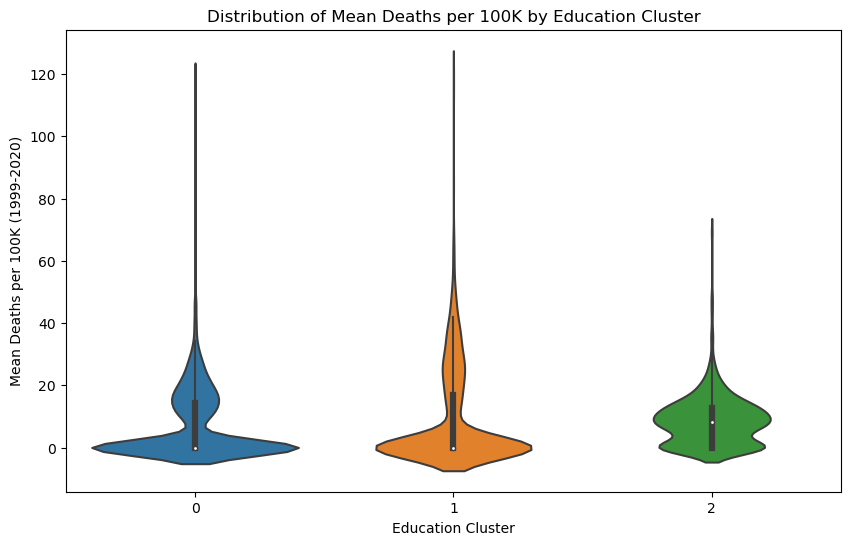

In [62]:
# construct a violin plot relating crime clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.violinplot(x='educ_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Education Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Education Cluster')

plt.show()


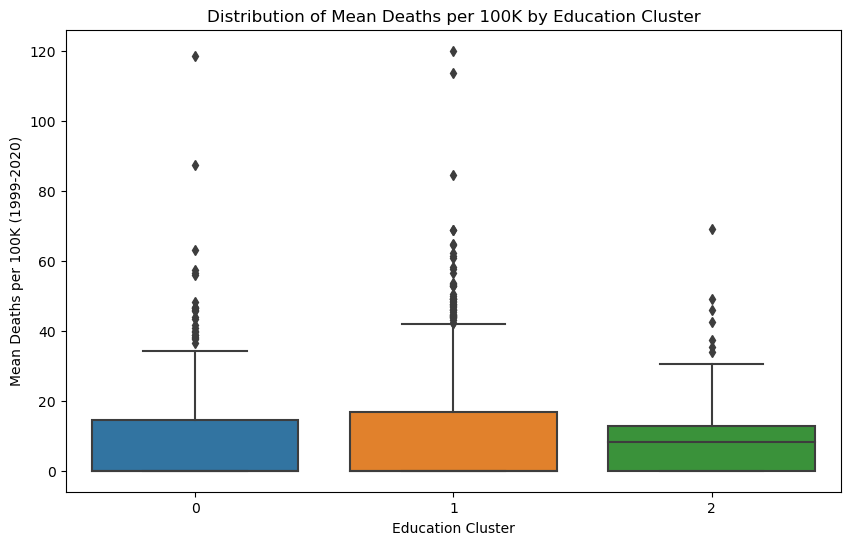

In [63]:
# construct a box plot relating education clustering and deaths per 100K mean

plt.figure(figsize=(10, 6))
sns.boxplot(x='educ_cluster', y='deaths_per_100K_mean (1999-2020)', data=counties_gvd_copy)

plt.xlabel('Education Cluster')
plt.ylabel('Mean Deaths per 100K (1999-2020)')
plt.title('Distribution of Mean Deaths per 100K by Education Cluster')

plt.show()

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

## END OF CODING